# Chapter 7 集成学习和随机森林

假设你随机向成千上万的人提出一个复杂的问题，然后汇总他们的答案。在许多情况下，您会发现这个聚合的答案比专家的答案要好。这被称为群众的智慧。类似地，如果您聚合了一组预测器（如分类器或回归器）的预测，那么您通常会得到比使用最好的单个预测器更好的预测。一组预测器称为 **集成（ensemble）** ；因此，这种技术称为 **集成学习（ensemble learning）** ，一种集成学习算法称为 **集成方法（ensemble method）** 。

作为集成方法的一个例子，您可以训练一组决策树分类器，每个分类器都在训练集的不同随机子集上。然后，您可以获得所有单个树的预测，而获得最多投票的类是集合的预测。这样的决策树集合被称为 **随机森林（random forest）** ，尽管它很简单，但这是当今最强大的机器学习算法之一。

正如在第2章中所讨论的，一旦您已经构建了一些很好的预测器，您将经常在项目接近结束时使用集成方法，从而将它们组合成一个更好的预测器。事实上，在机器学习竞赛中获胜的解决方案通常涉及几种集成方法——最著名的是Netflix奖竞赛。

在本章中，我们将研究最流行的集成方法，包括 **投票分类器（voting classifiers）**、**放回取样和不放回取样集成（bagging pasting ensembles）** 、**随机森林（random forests）**、**增强（boosting）** 和 **堆叠集成（stacking ensembles）**。

## Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

##  1. 投票分类器（Voting Classifiers）

假设您训练了一些分类器，每个分类器都达到80%的准确率。您可能有一个逻辑回归分类器，一个SVM分类器，一个随机森林分类器，一个k近邻分类器，也许还有其他一些分类器。

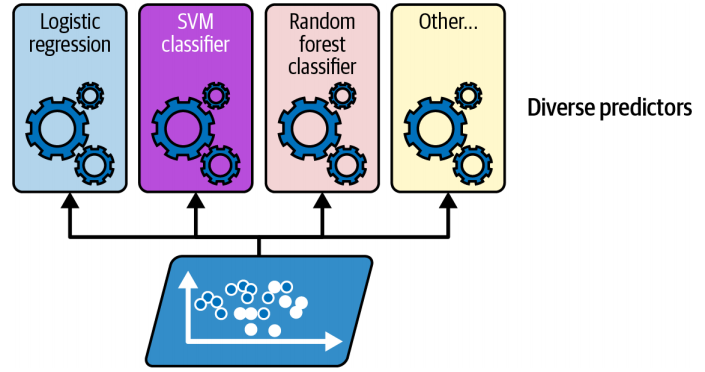

创建一个更好的分类器的一个非常简单的方法是聚合每个分类器的预测：获得最多投票的类是集成的预测。这种多数投票分类器被称为 **硬投票分类器（hard voting classifier）** 。

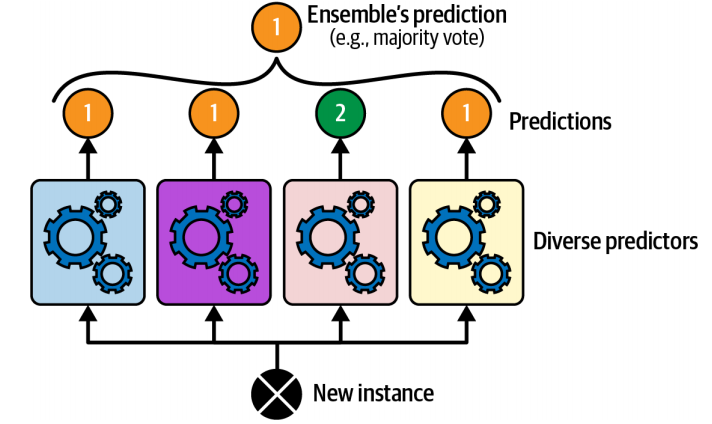

有些令人惊讶的是，这种投票分类器通常比集成中最好的分类器获得更高的精度。事实上，即使每个分类器都是一个弱学习者（这意味着它只比随机猜测稍微好一点），集成仍然可以是一个较强的学习者（实现较高的准确性），只要集成中有足够数量的弱学习者，并且它们具有足够的多样化。

这怎么可能？下面的类比可以帮助阐明这个谜团。假设你有一个有偏的硬币，它有51%的机会正面朝上和49%的机会背面朝上。如果你投掷它1000次，你通常会得到或多或少的510个正面和490个背面，因此会有大部分的正面。如果你仔细算一下，你会发现在1000次投掷后获得大部分正面的概率接近75%。你扔硬币越多，概率就越高（例如，扔10000次，概率就会超过97%）。这是由于大数定律：当你不断抛硬币时，正面的比例越来越接近正面的概率（51%）。

下图显示了10组有偏的掷硬币。你可以看到，随着投掷次数的增加，正面的比例接近51%。最终，所有10个系列都接近51%，因此它们始终在50%以上。

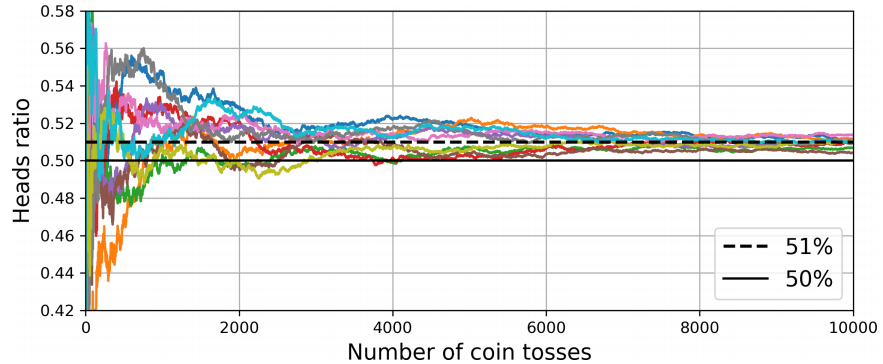

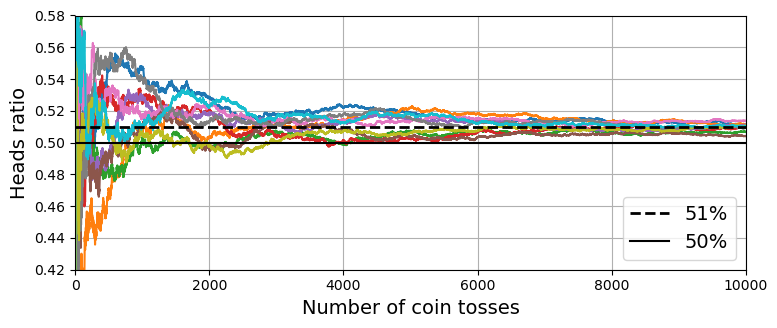

In [5]:
# extra code – this cell generates and saves Figure 7–3

import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
save_fig("law_of_large_numbers_plot")
plt.show()

类似地，假设您构建了一个包含1000个分类器的集成，这些分类器的个体正确率只有51%（几乎不比随机猜测好）。如果你预测大多数投票的类，你可以希望有高达75%的准确率！然而，这**只有当所有分类器都是完全独立的时才成立**，产生不相关的错误，这显然不是事实，因为它们是在相同的数据上训练的。他们很可能会犯相同类型的错误，所以会有许多多数人投票给错误的类别，从而降低集合的准确性。

**注意**：当预测器尽可能地相互独立时，集成方法的工作效果最好。获得不同分类器的一种方法是使用非常不同的算法来训练它们。这增加了它们产生非常不同类型的错误的机会，提高了集成的准确性。

Scikit-Learn 提供了一个非常容易使用的 **VotingClassifier** 类：只需给它一个名称/预测器对的列表，并像一个普通的分类器一样使用它。让我们在月球数据集上尝试一下（在第5章中介绍）。我们将加载月球数据集分割成一个训练集和一个测试集，然后我们将创建和训练一个由三个不同分类器组成的投票分类器：

In [6]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

当你 fit 一个 **VotingClassifier** 时，它克隆每个估计器并 fit 克隆的估计器。原始估计器通过 **estimators** 属性获得，而拟合的克隆估计器可以通过 **estimators_** 属性获得。如果您更喜欢字典而不是列表，您可以使用 **named_estimators** 或 **named_estimators_** 。首先，让我们来看看每个拟合的分类器在测试集上的准确性：

In [7]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


当你调用投票分类器的 **predict()** 方法时，它会执行硬投票。例如，投票分类器为测试集的第一个实例预测类1，因为三个之二的分类器预测该类：

In [8]:
voting_clf.predict(X_test[:1])

array([1], dtype=int64)

In [9]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64)]

现在让我们来看看投票分类器在测试集上的性能：

In [10]:
voting_clf.score(X_test, y_test)

0.912

你知道了！投票分类器的性能优于所有单独的分类器。

如果所有的分类器都能够估计类概率（即，如果它们都有一个 **predict_proba()** 方法），那么您可以告诉 Scikit-Learn 以最高的类概率预测类，即所有单独分类器的平均值。这被称为 **软投票（soft voting）** 。**软投票通常比硬投票取得更高的表现，因为它更重视高度自信的选票**。您所需要做的就是将投票类分类器的 **voting** 超参数设置为“**soft**”，并确保所有分类器都可以估计类的概率。默认情况下，SVC 类不是这样的，所以您需要将它的 **probability** 超参数设置为 **True**（这将使 SVC 类使用交叉验证来估计类的概率，会减慢训练，并将添加一个 **predict_proba()** 方法）。让我们试一试：

In [11]:
voting_clf.voting = "soft"

voting_clf.named_estimators["svc"].probability = True

voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

我们只需使用软投票就能达到92%的准确率——还不错！

## 2. 放回取样和不放回取样（Bagging and Pasting）

正如刚才讨论的那样，获得一组不同分类器的一种方法是使用非常不同的训练算法。另一种方法是对每个预测器使用相同的训练算法，但在训练集的不同随机子集上训练它们。当通过替换执行采样时，这种方法称为 **bagging**（bootstrap aggregating 的缩写）。当不放回地进行采样时，称为 **pasting** 。

换句话说，**bagging** 和 **pasting** 都允许在多个预测器中对训练实例进行多次采样，但只有 **bagging** 允许对同一预测器对训练实例进行多次采样。这个采样和训练过程如图所示。

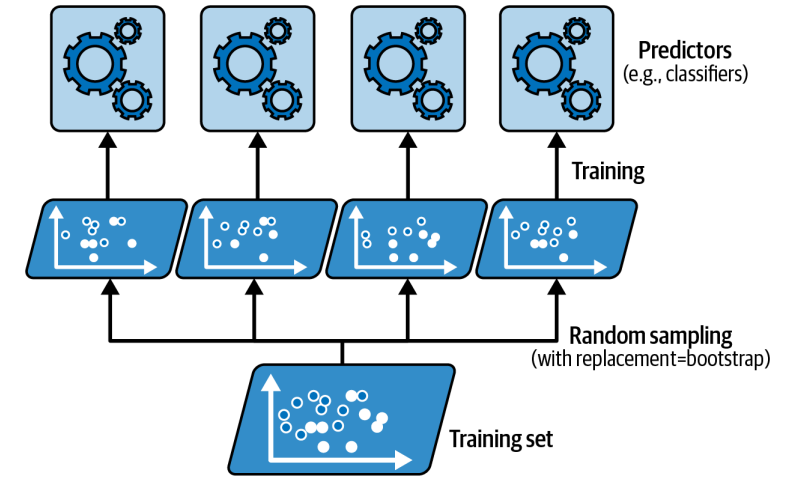

一旦所有的预测器都被训练好了，集成就可以通过简单地聚合所有预测器的预测来对一个新的实例进行预测。聚合函数通常是用于分类的 **统计模式（statistical mode）**（即，最频繁的预测，就像使用硬投票分类器一样），或回归的平均值。每个单独的预测器都比在原始训练集上训练有更高的偏差，但聚合减少了偏差和方差。一般来说，最终的结果是，集成比在原始训练集上训练的单一预测器具有类似的偏差，但方差更低。

如上图所示，预测器都可以通过不同的 CPU 内核，甚至是不同的服务器进行并行训练。同样地，预测也可以并行地做出。这就是 **bagging** 和 **pasting** 方法如此流行的原因之一：它们的可扩展性非常好。

### 2.1 在 Scikit-Learn 中的放回取样和不放回取样（Bagging and Pasting in Scikit-Learn）

Scikit-Learn 提供了一个简单的 **bagging** 和 **pasting** 的API：**BaggingClassifier** 类（或用于回归的 **BaggingRegressor**）。

下面的代码训练了500个决策树分类器的集合：每个分类器都是对从训练集中随机抽取的100个训练实例进行训练的（这是一个 **bagging** 的例子，但如果你想使用 **pasting** ，只需设置 **bootstrap=False**）。**n_jobs** 参数告诉 Scikit-Learn 用于训练和预测的 CPU 内核数，以及 -1 告诉 Scikit-Learn 使用所有可用的内核：

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            max_samples=100, n_jobs=-1,
                            random_state=42)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

**注意**：如果基本分类器能够估计类的概率（即，如果它有一个 **predict_proba()** 方法），那么 **BaggingClassifier** 就会自动执行软投票而不是硬投票，这就是决策树分类器的情况。

下图比较了单个决策树的决策边界与500棵树（来自前面的代码）的决策边界，两者都是在卫星数据集上训练的。正如您所看到的，集成的预测可能比单个决策树的预测概括得更泛化：集成具有可比较的偏差，但方差较小（它在训练集上产生大致相同数量的错误，但决策边界不那么不规则）。

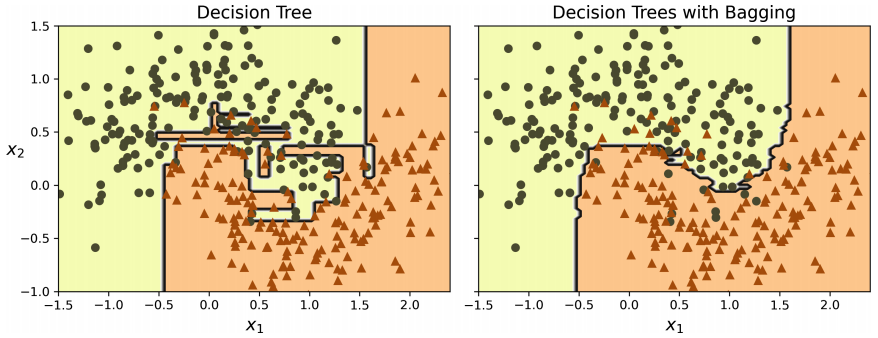

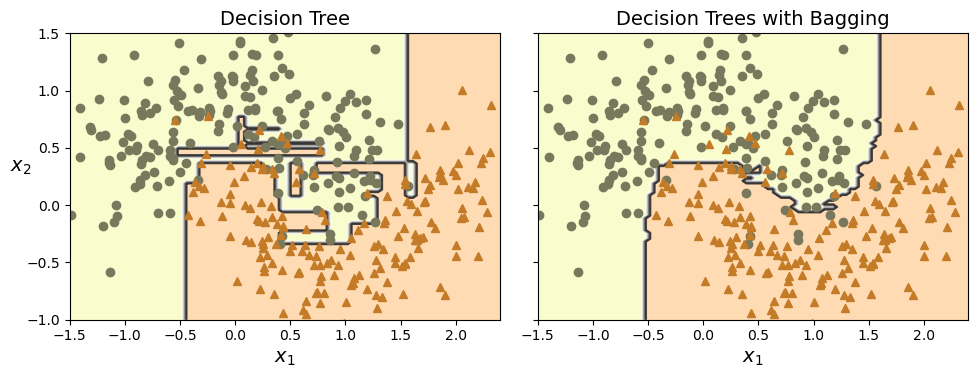

In [13]:
# extra code – this cell generates and saves Figure 7–5

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

**bagging** 在每个预测器训练的子集中引入了更多的多样性，因此 **bagging** 最终会比 **pasting** 产生更高的偏差；但额外的多样性也意味着预测变量最终的相关性较低，因此整体的方差会减少。总的来说，**bagging** 通常会产生更好的模型，这也解释了为什么它通常是首选。但是如果你有空闲时间和 CPU 能力，你可以使用交叉验证来评估 **bagging** 和 **pasting** 并选择效果最好的一个。

### 2.2 袋外估测（Out-of-Bag Evaluation）

使用 **bagging**，对于任何给定的预测器，一些训练实例可能会被多次采样，而其他的可能根本不会被采样。默认情况下，**BaggingClassifier** 对 **m** 个带替换的训练实例进行采样 (**bootstrap=True**)，其中 **m** 是训练集的大小。 通过这个过程，可以从数学上表明，对于每个预测变量，平均只有大约 63% 的训练实例被采样。其余 37% 的未被采样的训练实例称为 **袋外（out-of-bag，OOB）** 实例. 请注意，对于所有预测变量，它们并非相同的 37%。

**bagging** 集成可以使用 **OOB** 实例进行评估，而不需要单独的验证集：实际上，如果有足够的估计器，那么训练集中的每个实例都可能是多个估计器的 OOB 实例，因此可以使用这些估计器为该实例做出公平的整体预测。一旦对每个实例都有预测，就可以计算集成的预测准确度（或任何其他指标）。

在 Scikit-Learn 中，您可以在创建 **BaggingClassifier** 时设置 **oob_score=True** ，以便在训练后请求一个自动的 OOB 评估。下面的代码就验证了这一点。结果的评估分数可在 **oob_score_** 属性中获得：

In [14]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500,
                            oob_score=True, n_jobs=-1, 
                            random_state=42)

bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.896

根据这个 OOB 的评估，该 **BaggingClassifier** 在测试集上很可能达到约89.6%的准确率。让我们验证一下：

In [15]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.92

我们得到了92%的测试准确率。OOB的评估有点过于悲观，略低于2%。

每个训练实例的 OOB 决策函数也可以通过 **oob_decision_function_** 属性获得。由于基估计器有一个 **predict_proba()** 方法，决策函数返回每个训练实例的类概率。例如，OOB 评估估计第一个训练实例有 67.6% 的概率属于正类，有 32.4% 的概率属于负类：

In [16]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

### 2.3 随机修补和随机子空间（Random Patches and Random Subspaces）

**BaggingClassifier** 类也支持对这些特性进行采样。采样由两个超参数控制：**max_features** 和 **bootstrap_features** 。它们的工作方式与 **max_samples** 和 **bootstrap** 相同，但可用于特征采样，而不是实例采样。因此，每个预测器都将在输入特征的一个随机子集上进行训练。

当您处理高维输入（如图像）时，这种技术特别有用，因为它可以大大加快训练速度。对训练实例和特征进行抽样称为 **随机修补（random patches）** 方法。

保留所有的训练实例（通过设置 **bootstrap=False** 和 **max_samples=1.0**），但是采样特征（通过将 **bootstrap_features** 设置为 **True** 和/或 **max_features** 设置为一个小于1.0的值）被称为 **随机子空间（Random Subspaces）** 方法。

抽样特征会导致更多的预测器多样性，用更多的偏差来换取更低的方差。

## 3. 随机森林（Random Forests）

正如我们所讨论过的，随机森林是一个决策树的集合，通常通过 bagging 方法（或有时 pasting）进行训练，通常将 **max_samples** 设置为训练集的大小。您可以使用 **RandomForestClassifier** 类，而不是构建 **BaggingClassifier** ，并传递给 **DecisionTreeClassifier** 类，它更方便为决策树优化（类似地，回归任务有一个 **RandomForestRegressor** 类）。下面的代码训练了一个包含 500 棵树的随机森林分类器，每棵树最多被限制为16个叶节点，使用所有可用的CPU核心：

In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)

rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

除了少数例外，**RandomForestClassifier** 具有 **DecisionTreeClassifier** 的所有超参数（以控制树的生长方式），以及 **BaggingClassifier** 的所有超参数来控制集成自身。

随机森林算法在生成树时引入了额外的随机性；它不是在分割节点时搜索最佳特征（见第6章），而是在随机特征子集中搜索最佳特征。默认情况下，它采样 $\sqrt{n}$ 个特征（其中 $n$ 是特征的总数）。该算法产生更大的树多样性，这以更高的偏差交换更低的方差，通常产生一个总体上更好的模型。因此，下面的 **BaggingClassifier** 等同于之前的 **RandomForestClassifier** ：

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [19]:
# extra code – verifies that the predictions are identical
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # same predictions

True

### 3.1 非常随机的树集成（Extra-Trees）

当您在随机森林中生成树时，在每个节点上只考虑特征的一个随机子集进行拆分（如前所述）。通过对每个特征使用随机阈值，而不是搜索可能的最佳阈值（就像常规决策树那样），可以使树更加随机。为此，在创建一个 **DecisionTreeClassifier** 时，简单地设置 **splitter="random"** 。

由这种非常随机的树组成的森林被称为 **非常随机的树集成**（或简称为 **extra-trees**）。同样，这种技巧用更多的偏差来换取更低的方差。它还使训练 **extra-trees** 分类器比常规随机森林快得多，因为在每个节点上为每个特征找到可能的最佳阈值是生长树最耗时的任务之一。

您可以使用 Scikit-Learn 的 **ExtraTreesClassifier** 类创建一个 **extra-trees** 分类器。它的 API 与 **RandomForestClassifier** 类相同，除了 **bootstrap** 默认为 **False** 。类似地，**ExtraTreesRegressor** 类与 **RandomForestRegressor** 类具有相同的API，除了 **bootstrap** 默认值为 **False** 。

**注意**：很难预先判断一个 **RandomForestClassifier** 的性能是比一个 **ExtraTreesClassifier** 更好还是更差。通常，唯一的了解方法是尝试两者，并使用交叉验证进行比较。

### 3.2 特征重要性（Feature Importance）

然而，随机森林的另一个重要性质是，它们易于测量每个特征的相对重要性。Scikit-Learn 通过查看使用该特征的树节点平均减少了多少不纯度来衡量一个特性的重要性。更准确地说，它是一个加权平均值，其中每个节点的权重等于与之相关的训练样本的数量。

Scikit-Learn 在训练后自动计算每个特征的分数，然后对结果进行缩放，使所有重要性的和等于1。您可以使用 **feature_importances_** 变量来访问结果。例如，下面的代码在 iris 数据集上训练一个 **RandomForestClassifier**（详见第4章），并输出每个特征的重要性。似乎最重要的特征是花瓣的长度（44%）和宽度（42%），而萼片的长度和宽度则相当不重要（分别为11%和2%）：

In [20]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)

rnd_clf.fit(iris.data, iris.target)

for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


类似地，如果您在 MNIST 数据集上训练一个随机森林分类器（见第3章）并绘制每个像素的重要性，您将得到如下图所示的图像。

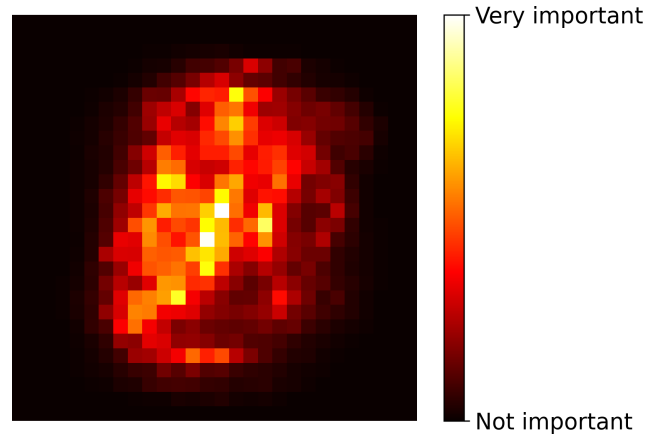

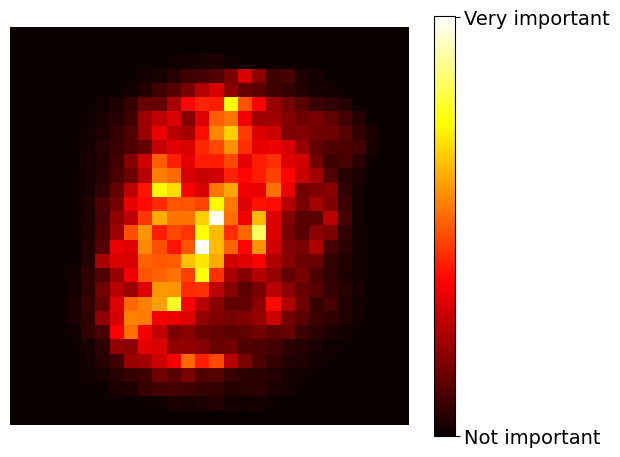

In [21]:
# extra code – this cell generates and saves Figure 7–6

from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)

plt.imshow(heatmap_image, cmap="hot")

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])

cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)

plt.axis("off")

save_fig("mnist_feature_importance_plot")

plt.show()

随机森林可以非常方便地快速了解特性，特别是当您需要执行特性选择时。

## 4. 增强（Boosting）

**Boosting**（最初称为 **hypothesis boosting**）是指任何可以将几个弱学习者组合成一个强学习者的集成方法。大多数增强方法的一般思想是按顺序训练预测器，每个预测器都试图纠正其前置预测器。有许多增强方法可用，但迄今为止最流行的是 **AdaBoost（adaptive boosting，自适应增强）** 和 **梯度增强（gradient boosting）** 。让我们从 AdaBoost 开始。

### 4.1 自适应增强（AdaBoost）

一个新的预测器纠正其前置预测器的一种方法是更多地关注前者欠拟合的训练实例。这就导致了越来越多的关注困难案例的新的预测器。这是 **AdaBoost** 所使用的技术。

例如，当训练一个 **AdaBoost** 分类器时，该算法首先训练一个基本的分类器（如决策树），并使用它来对训练集进行预测。然后，该算法增加错误分类的训练实例的相对权重。然后使用更新后的权值训练第二个分类器，并再次对训练集进行预测，更新实例权值，以此类推，见下图。

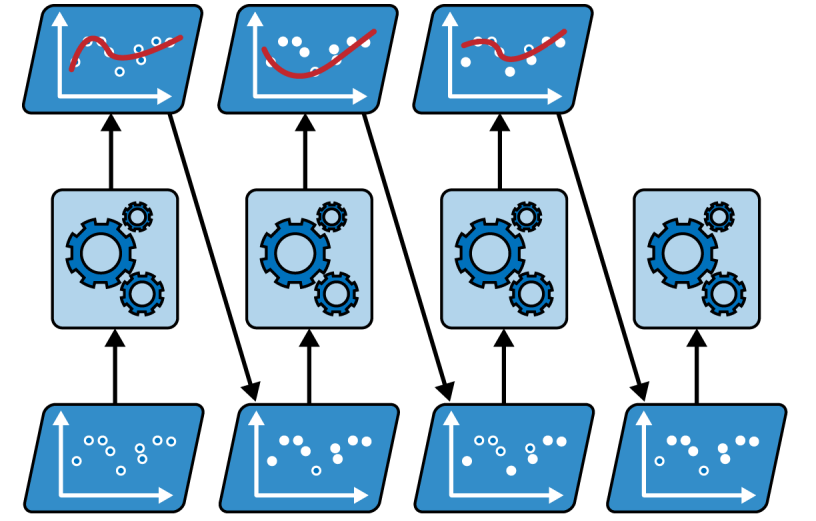

下图显示了 moons 数据集上五个连续预测器的决策边界（在本例中，每个预测器都是一个具有 RBF 内核的高度正则化的 SVM 分类器）。第一个分类器将许多实例弄错了，因此它们的权重得到提升。因此，第二个分类器在这些实例上做得更好，依此类推。 右边的图表示相同的预测变量序列，除了学习率减半（即，错误分类的实例权重在每次迭代中提升得更少）。如您所见，这种顺序学习技术与梯度下降有一些相似之处，不同之处在于 AdaBoost 不是调整单个预测器的参数来最小化成本函数，而是将预测器添加到集成中，逐渐使其变得更好。

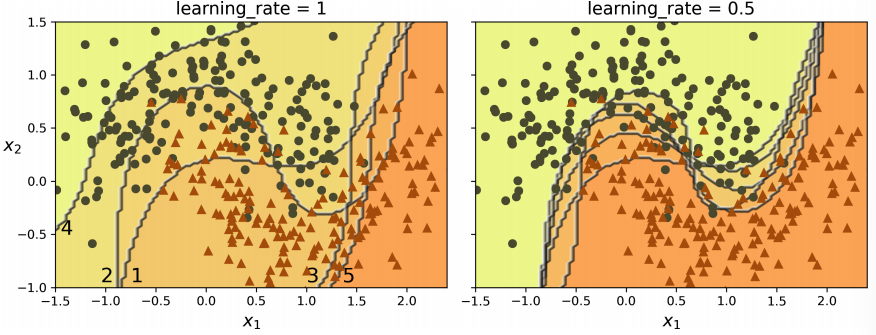

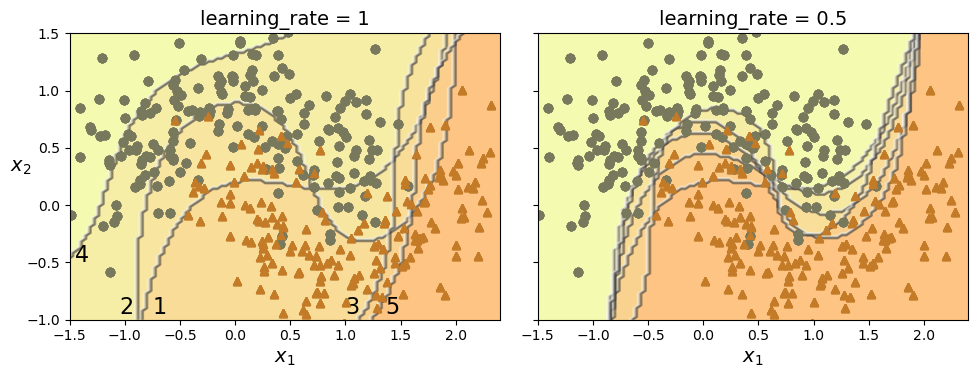

In [22]:
# extra code – this cell generates and saves Figure 7–8

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

一旦所有预测器都经过训练，集成就可以进行非常类似于 **bagging** 或 **pasting** 的预测，除了预测器具有不同的权重，具体取决于它们在加权训练集上的整体准确性。

**注意**：这种顺序学习技术有一个重要的缺点：训练不能并行化，因为每个预测器只有在之前的预测器被训练和评估后才能进行训练。因此，它不像 **bagging** 或 **pasting** 一样易于扩展。

让我们仔细看一下 **AdaBoost** 算法。每个实例的权重 $w^{(i)}$ 最初被设置为 $\frac1m$ 。对第一个预测器进行训练，并在训练集上计算其加权误差率 $r_1$；见公式。

**第 $j$ 个预测器的加权错误率**：

$$ r_j=\sum_{i=1,\hat{y}_j^{(i)}\ne y^{(i)}}^mw^{(i)} $$

其中，$\hat{y}_j^{(i)}$ 是第 $j$ 个预测器对于第 $i$ 个实例的预测。

然后使用如下公式计算预测器的权重 $\alpha_j$ ，其中 $\eta$ 是学习率超参数（默认为1）。预测器越准确，其权重就越高。如果它只是随机猜测，那么它的权重将接近于零。然而，如果它通常是错误的（也就是说，不如随机猜测准确），那么它的权重将是负的。

**预测器权重**：

$$ \alpha_j=\eta log\frac{1-r_j}{r_j} $$

接下来，**AdaBoost** 算法使用如下公式更新实例的权重，这增加了错误分类的实例的权重。

**权重更新规则**：

$$  w^{(i)}\leftarrow\left\{
\begin{array}{rcl}
w^{(i)}  & {if\ \hat{y}_j^{(i)}=y^{(i)}}\\
w^{(i)}exp(\alpha_j)  & {if\ \hat{y}_j^{(i)}\ne y^{(i)}}
\end{array} \right. , for\ i=1,2,\cdots,m
$$

然后将所有实例的权重归一化（即，除以 $\sum_{i=1}^mw^{(i)}$）。

最后，使用更新后的权值训练一个新的预测器，并重复整个过程：计算新的预测器的权值，更新实例权值，然后训练另一个预测器，以此类推。当达到期望的预测器数量时，或者当找到一个完美的预测器时，该算法就会停止。

为了做出预测，**AdaBoost** 只是计算所有预测器的预测，并使用预测器的权重 $\alpha_j$ 对它们进行加权。预测的类别是获得多数加权选票的类别。

**AdaBoost 预测**：

$$ \hat{y}(\pmb{x})=\arg \max_{k}\sum_{j=1, \hat{y}_j(\pmb{x})=k}^N\alpha_j $$

其中 $N$ 是预测器的数量。

Scikit-Learn 使用了一个名为 **SAMME** 的多类版本（它代表使用 **Stagewise Additive Modeling using a Multiclass Exponential loss function，多类指数损失函数的分段加性建模**）。当只有两个类时，SAMME 相当于 AdaBoost 。如果预测器可以估计类概率（例如，如果他们有一个 **predict_proba()** 方法），Scikit-Learn 可以使用一种叫做 **SAMME.R** 的 **SAMME** 变体，它依赖于类概率而不是预测，通常表现得更好。

以下代码使用 Scikit-Learn 的 **AdaBoostClassifier** 类（如您所料，还有一个 **AdaBoostRegressor** 类）基于 30 个决策树桩训练 **AdaBoost** 分类器。决策树桩是 **max_depth=1** 的决策树——换句话说，是由单个决策节点和两个叶节点组成的树。这是 **AdaBoostClassifier** 类的默认基础估计器：

In [23]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

**注意**：如果您的 AdaBoost 集成对训练集过拟合，您可以尝试减少估计器的数量或更强地正则化基础估计器。

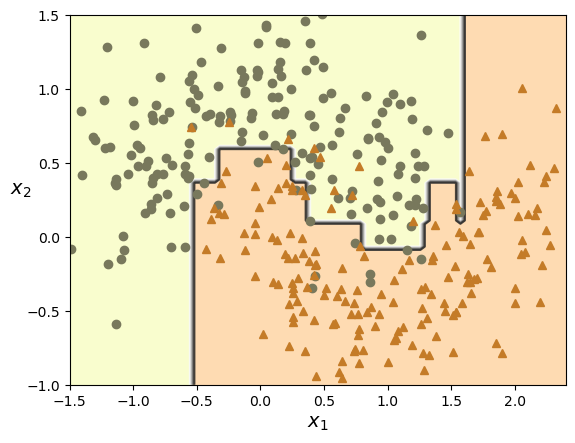

In [24]:
# extra code – in case you're curious to see what the decision boundary
#              looks like for the AdaBoost classifier

plot_decision_boundary(ada_clf, X_train, y_train)

### 4.2 梯度增强（Gradient Boosting）

另一个非常流行的增强算法是 **梯度增强（gradient boosting）** 算法。就像 **AdaBoost** 一样，梯度增强的工作原理是通过依次向一个集合中添加预测器，每个预测器都要纠正它的前身。然而，该方法不像 **AdaBoost** 那样在每次迭代中调整实例的权重，而是试图将新的预测器与前一个预测器所产生的残差相匹配。

让我们通过一个简单的回归示例，使用决策树作为基本的预测器；这被称为 **梯度树增强（gradient tree boosting）** ，或 **梯度增强回归树（gradient boosted regression trees，GBRT）** 。首先，让我们生成一个有噪声的二次数据集，并拟合一个 **DecisionTreeRegressor** ：

In [25]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

接下来，我们将根据第一个预测器的残差训练第二个 **DecisionTreeRegressor** ：

In [29]:
y2 = y - tree_reg1.predict(X)

tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)

tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

然后我们将训练第二个预测器的残差：

In [30]:
y3 = y2 - tree_reg2.predict(X)

tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)

tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

现在我们有了一个包含三棵树的集合。它可以简单地通过合并所有树的预测来对一个新的实例进行预测：

In [31]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

下图在左列中表示这三棵树的预测，在右列中表示集成的预测。在第一行中，集合只有一棵树，所以它的预测与第一棵树的预测完全相同。在第二行中，根据第一棵树的残差来训练一棵新的树。在右边，你可以看到，集合的预测等于前两棵树的预测之和。类似地，在第三行中，另一棵树是根据第二棵树的残差进行训练。您可以看到，随着树被添加到集成中，集成的预测会逐渐变得更好。

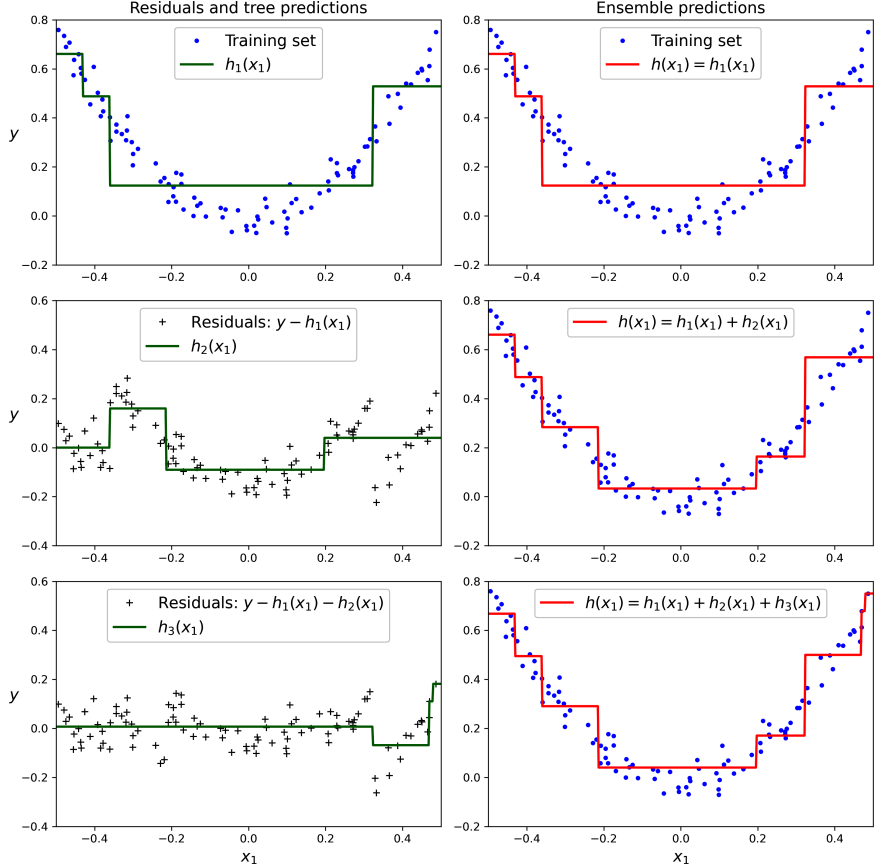

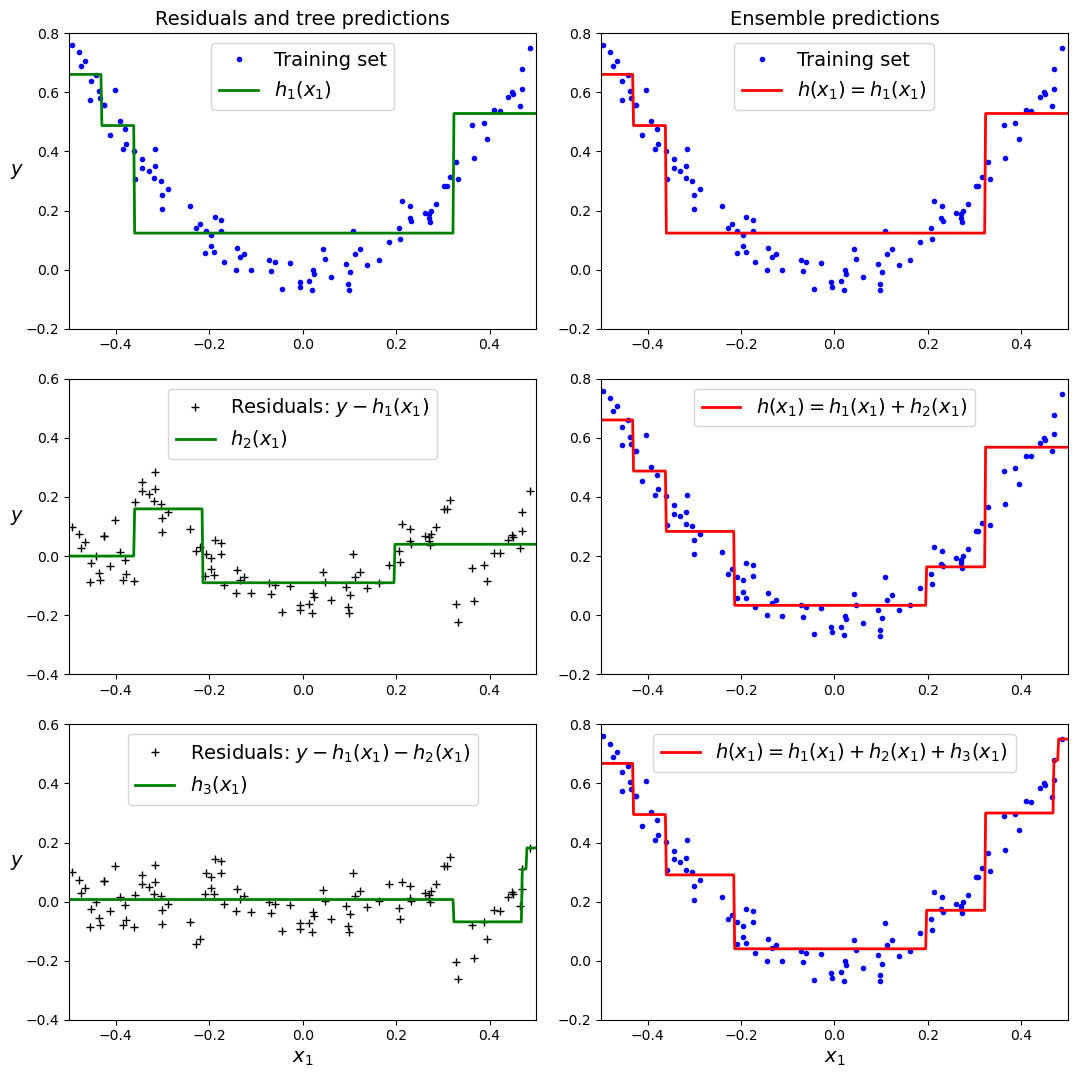

In [32]:
# extra code – this cell generates and saves Figure 7–9

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

save_fig("gradient_boosting_plot")
plt.show()

你可以使用 Scikit-Learn 的 **GradientBoostingRegressor** 类来更容易地训练 GBRT 集成（还有一个用于分类的 **GradientBoostingClassifier** 类）。与 **RandomForestRegressor** 类一样，它有超参数来控制决策树的增长（例如 **max_depth**，**min_samples_leaf**），以及控制集成训练的超参数，如树的数量（**n_estimators**）。下面的代码创建了与前一个代码相同的集成：

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)

gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

**learning_rate** 超参数缩放了每棵树的贡献。如果您将它设置为一个较低的值，比如0.05，您将需要集成中的更多的树来拟合训练集，但预测通常会更好地泛化。这是一种被称为 **收缩（shrinkage）** 的正则化技术。

下图显示了两个使用不同超参数训练的GBRT集合：左边的一个没有足够的树来拟合训练集，而右边的一个则有大约正确的数量。如果我们添加更多的树，GBRT 将开始过拟合训练集。

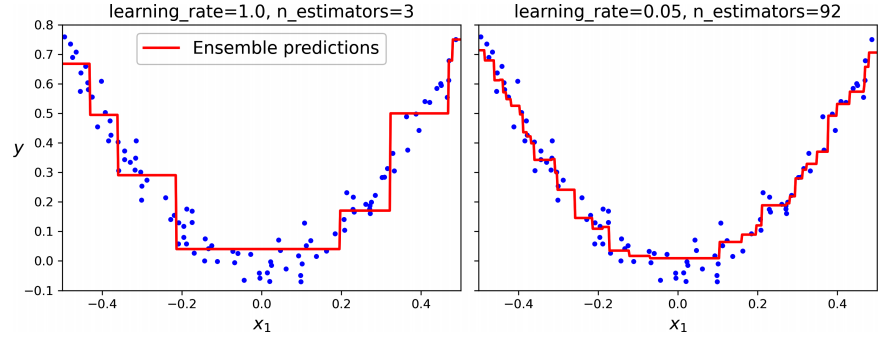

为找到最优的树数量，你可以使用 **GridSearchCV** 或 **RandomizedSearchCV** 执行交叉验证，像往常一样，但有一个更简单的方法：如果你将 **n_iter_no_change** 超参数设置为一个整数值，比如 10，那么 **GradientBoostingRegressor** 如果在训练期间如果看到最后 10 棵树没有帮助将自动停止添加更多的树。这只是简单的早期停止（在第4章中介绍），但需要一点耐心：它容忍在停止之前的几次迭代没有进展。让我们用早期停止来训练集成：

In [35]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)

gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

如果你将 **n_iter_no_change** 设置得太低，训练可能会过早停止，模型将会欠拟合。但如果你把它设置得太高，它就会过拟合。我们还设置了一个相当小的学习率和一个高数量的估计器，但由于早期停止，训练集成中的实际估计量数量要低得多：

In [36]:
gbrt_best.n_estimators_

92

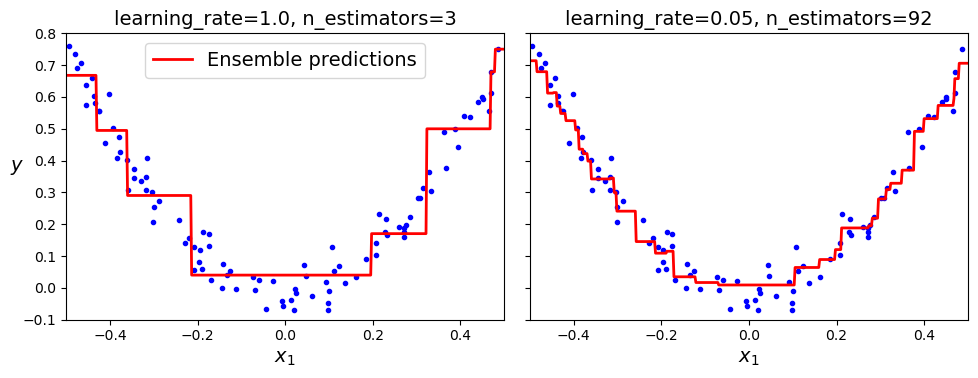

In [37]:
# extra code – this cell generates and saves Figure

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

save_fig("gbrt_learning_rate_plot")
plt.show()

当 **n_iter_no_change** 被设置时，**fit()** 方法自动将训练集分割成一个更小的训练集和一个验证集：这允许它在每次添加一个新树时评估模型的性能。验证集的大小由 **validationfraction** 超参数控制，默认情况下为 10% 。**tol** 超参数决定了仍然可忽略不计的最大性能改进，默认为 0.0001 。

**GradientBoostingRegressor** 类还支持一个 **subsample** 超参数，它指定了用于训练每棵树的训练实例的比例。例如，如果 **subsample=0.25** ，那么每棵树都是在随机选择的 25% 的训练实例上进行训练的。正如您现在可能已经猜到的那样，这种技术可以用更高的偏差来换取更低的方差。它还大大加快了训练的速度。这被称为 **随机梯度提升（stochastic gradient boosting）** 。

### 4.3 基于直方图的梯度提升（Histogram-Based Gradient Boosting）

Scikit-Learn 还提供了另一个 GBRT 实现，针对大型数据集进行了优化：**基于直方图的梯度增强（histogram-based gradient boosting，HGB）**。它的工作原理是将输入特性打包成箱，用整数替换它们。打包成箱的数量由 **max_bins** 超参数控制，默认该超参数为 255 ，不能设置为高于此。打包可以大大减少训练算法需要评估的可能阈值的数量。此外，使用整数使得使用更快、更高效的数据结构成为可能。而构建箱子的方式则消除了在训练每棵树时对特征进行排序的需要。

因此，该实现的计算复杂度为 $O(b\times m)$ ，而不是 $O(n\times m\times log(m))$ ，其中 $b$ 是箱子数，$m$ 是训练实例的数量，$n$ 是特征的数量。在实践中，这意味着 HGB 在大型数据集上的训练速度可以比常规的 GBRT 快数百倍。然而，装箱会导致精度损失，这就像一个正则化器一样：根据数据集的不同，这可能有助于减少过拟合，或者它可能导致过拟合。

Scikit-Learn 为 HGB 提供了两个类：**HistGradientBoostingRegressor** 和 **HistGradientBoostingClassifier** 。它们类似于 **GradientBoostingRegressor** 和 **GradientBoostingClassifier** ，但有一些显著的区别：

- 如果实例数大于 10000 个，则会自动激活提前停止。通过将 **early_stopping** 超参数设置为 True 或 False ，您可以始终打开或始终关闭早期停止。
- 不支持子采样。
- **n_estimators** 被重命名为 **max_iter** 。
- 唯一可以调整的决策树超参数是 **max_leaf_nodes** 、**min_samples_leaf** 和 **max_depth** 。

HGB 类还有两个很好的特性：它们同时支持 **分类特征** 和 **缺失值** 。这大大简化了预处理。但是，分类特征必须表示为从 0 到低于 **max_bins** 的数字的整数。您可以使用 **OrdinalEncoder** 。例如，下面是如何为第二章中介绍的加州住房数据集构建和训练一个完整的管道：

In [38]:
# extra code – at least not in this chapter, it's presented in chapter 2

import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

housing_labels = train_set["median_house_value"]

housing = train_set.drop("median_house_value", axis=1)

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder 

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)

hgb_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

整个 pipeline 和 imports 一样短！不需要 imputer、scaler 或 One-hot encoder，所以它真的很方便。请注意，**categorical_features** 必须设置为分类列索引（或一个布尔数组）。在没有任何超参数调优的情况下，该模型产生的RMSE约为47600，这还不算太糟。

In [40]:
# extra code – evaluate the RMSE stats for the hgb_reg model

from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

count       10.000000
mean     47613.307194
std       1295.422509
min      44963.213061
25%      47001.233485
50%      48000.963564
75%      48488.093243
max      49176.368465
dtype: float64

**注意**：在 Python ML 生态系统中还可以使用其他几个梯度增强的优化实现库：特别是 **[XGBoost](https://github.com/dmlc/xgboost)** 、 **[CatBoost](https://catboost.ai/)** 和 **[LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/)** 。它们都是专门用于梯度增强的，它们的 API 与 Scikit-Learn 非常相似，它们提供了许多额外的功能，包括 GPU 加速；你一定要看看！此外，TensorFlow 随机森林库还提供了各种随机森林算法的优化实现，包括平原随机森林、额外的树、GBRT等。

## 5. 堆叠（Stacking）

我们将在本章中讨论的最后一种集成方法称为 **堆叠stacking（堆叠泛化stacked generalization的缩写）**。它基于一个简单的想法：不是使用简单的函数（例如硬投票）来聚合集成中所有预测变量的预测 ，我们为什么不训练一个模型来执行这种聚合？下图显示了这样一个在新实例上执行回归任务的集成。底部的三个预测器中的每一个都预测不同的值（3.1、2.7 和 2.9），然后最终预测器（称为 **混合器blender** 或 **元学习器meta learner**）将这些预测作为输入并做出最终预测（3.0）。

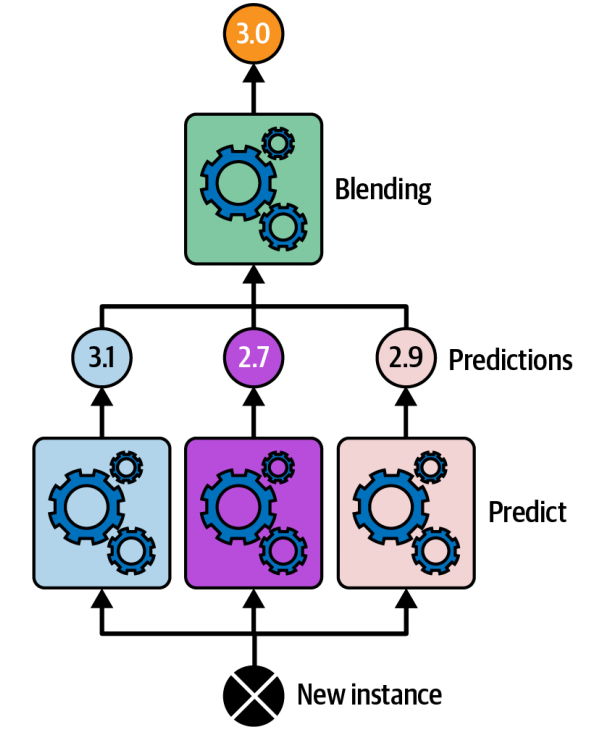

要训练 **混合器 blender**，您首先需要构建混合训练集。 您可以对集成中的每个预测器使用 **cross_val_predict()** 以获得原始训练集中每个实例的样本外预测，并将这些用作训练混合器的输入特征；目标可以简单地从原始训练集中复制。请注意，无论原始训练集中的特征数量如何（本例中只有一个），混合训练集中每个预测变量都将包含一个输入特征（本例中为三个）。一旦混合器被训练，基础预测器将在完整的原始训练集上最后一次重新训练。

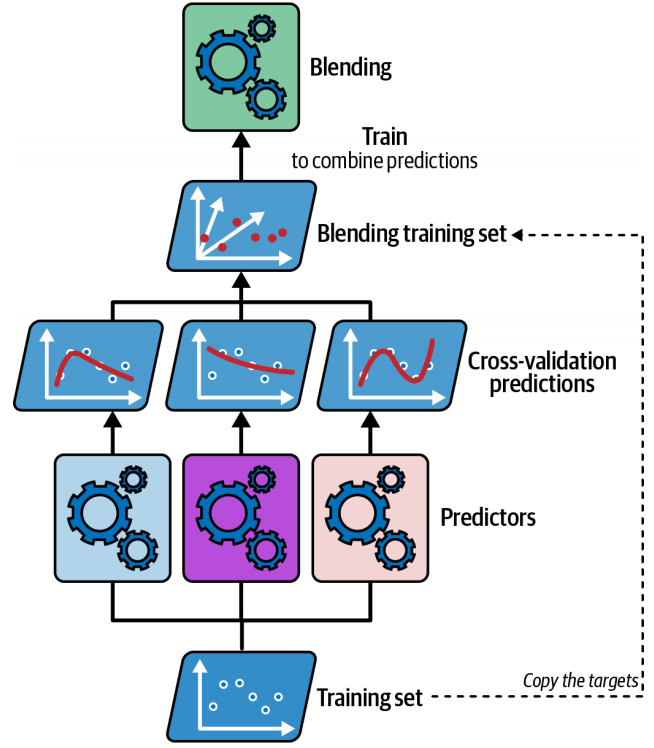

实际上，可以用这种方式训练几种不同的 **混合器 blender**（例如，一种使用线性回归，另一种使用随机森林回归）来得到一整层混合器，然后在其上添加另一个混合器来产生最终的预测，如下图所示。您可能可以通过这样做来挤出更多的性能下降，但这将花费您的训练时间和系统复杂性：

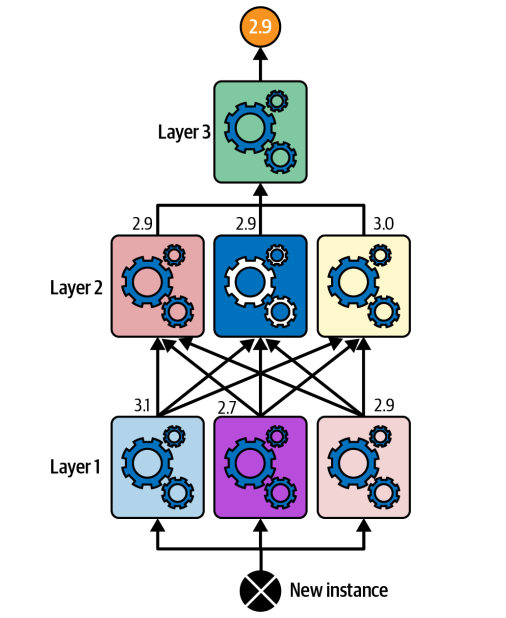

Scikit-Learn 为堆叠集成提供了两个类：**StackingClassifier** 和 **StackingRegressor** 。例如，我们可以用 **StackingClassifier** 替换我们本章开头在月球数据集上使用的 **VotingClassifier** ：

In [41]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

对于每个预测器，如果 **predict_proba()** 可用，堆叠分类器将调用 **predict_proba()** ；如果没有，它将回落到 **decision_function()** ，或者，作为最后的手段，调用 **predict()** 。如果你不提供一个最终的估计器，**StackingClassifier** 将使用 **LogisticRegression** ，**StackingRegressor** 将使用 **RidgeCV* 。

如果你在测试集上评估这个堆叠模型，你会发现92.8%的准确率，这比使用软投票的投票分类器要好一些，后者得到了92%。

In [42]:
stacking_clf.score(X_test, y_test)

0.928

总之，集成方法是通用的、强大的，使用起来相当简单。随机森林、AdaBoost 和 GBR T是大多数机器学习任务的第一批模型，它们在异构表格数据中尤其突出。此外，由于它们只需要很少的预处理，所以它们非常适合快速启动和运行原型。最后，像投票分类器和堆叠分类器这样的集成方法可以帮助您将系统的性能推到极限。